In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


## Evaluating the fit of stationary vs nonstationary gaussian processes
Fitting a stationary model helps avoid small eigenvlues when cov mat is computed with a small number of patches

In [2]:
# load images, extract patches, and compute cov mats
num_images = 25000
num_test_set_patches = 5000
edge_crop = 32
patch_size = 15
num_patches_to_use = np.array([2, 8, 32, 128, 512, 2048, 8192, 32768])
num_patches = num_patches_to_use.max()
channel = 'DPC_Right'
# channel = 'LED119'


all_images = load_bsccm_images(bsccm, channel=channel, num_images=num_images + num_test_set_patches, edge_crop=edge_crop, median_filter=False)
images = all_images[:num_images]
test_set_images = all_images[num_images:]
patches = extract_patches(images, patch_size, num_patches=num_patches)
test_set_patches = extract_patches(test_set_images, patch_size, num_patches=num_test_set_patches)

cov_mats = []
cov_mats_pd = []
non_stationary_means = []
cov_mats_stationary = []
cov_mats_stationary_pd = []
for n_patches in tqdm(num_patches_to_use):
    cov_mat = compute_cov_mat(patches[:n_patches])
    cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=1, show_plot=False)
    mean = np.mean(patches[:n_patches], axis=0).flatten()
    cov_mat_stationary = compute_stationary_cov_mat(patches[:n_patches])
    cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)
    cov_mats.append(cov_mat)
    cov_mats_pd.append(cov_mat_pd)
    non_stationary_means.append(mean)
    cov_mats_stationary.append(cov_mat_stationary)
    cov_mats_stationary_pd.append(cov_mat_stationary_pd)

100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


Text(0.5, 0.98, 'Eigenvalues of stationary and non-stationary covariance matrices vs dataset size')

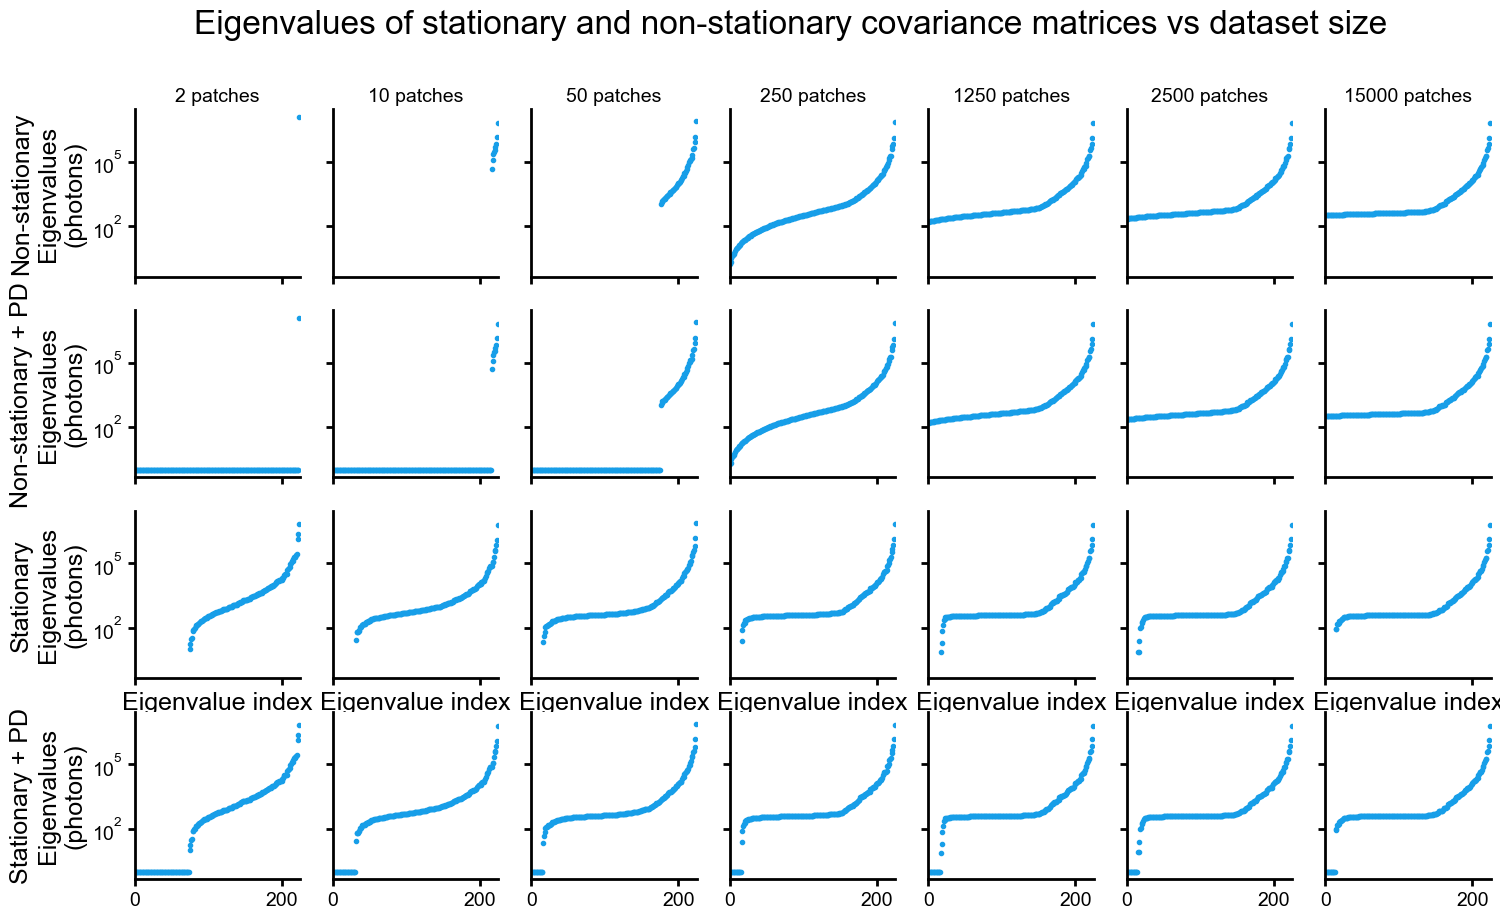

In [3]:
fig, ax = plt.subplots(4, num_patches_to_use.shape[0], figsize=(num_patches_to_use.shape[0] * 2.5, 10), sharex=True, sharey=True)

for i in range(len(cov_mats)):
    eigs = np.linalg.eigvalsh(cov_mats[i])
    eigs_pd = np.linalg.eigvalsh(cov_mats_pd[i])
    eigs_stationary = np.linalg.eigvalsh(cov_mats_stationary[i])
    eigs_stationary_pd = np.linalg.eigvalsh(cov_mats_stationary_pd[i])
    ax[0, i].semilogy(eigs, '.')
    ax[1, i].semilogy(eigs_pd, '.')
    ax[2, i].semilogy(eigs_stationary, '.')
    ax[3, i].semilogy(eigs_stationary_pd, '.')
    clear_spines(ax[0, i])
    clear_spines(ax[1, i])
    clear_spines(ax[2, i])
    clear_spines(ax[3, i])

    ax[0, i].set_title(f'{num_patches_to_use[i]} patches')
    if i == 0:
        ax[0, i].set_ylabel('Non-stationary\nEigenvalues\n(photons)')
        ax[1, i].set_ylabel('Non-stationary + PD\nEigenvalues\n(photons)')
        ax[2, i].set_ylabel('Stationary\nEigenvalues\n(photons)')
        ax[3, i].set_ylabel('Stationary + PD\nEigenvalues\n(photons)')
    ax[2, i].set(xlabel='Eigenvalue index', xlim=[0, len(eigs)])


fig.suptitle('Eigenvalues of stationary and non-stationary covariance matrices vs dataset size') 

### Compute likelihood on held out test set

In [4]:

test_data = test_set_patches.reshape(test_set_patches.shape[0], -1)
# compute log likelihood of test set
log_likelihoods_full_mean = []
log_likelihoods_full_confidence_interval = []
log_likelihoods_stationary_mean = []
log_likelihoods_stationary_confidence_interval = []
for i in tqdm(range(len(num_patches_to_use))):
    mean, interval = run_bootstrap(test_data, 
                                   lambda x: np.mean(jax.scipy.stats.multivariate_normal.logpdf(x, mean=non_stationary_means[i], cov=cov_mats_pd[i])), 
                                   num_bootstrap_samples=10, confidence_interval=90)
    log_likelihoods_full_mean.append(mean)
    log_likelihoods_full_confidence_interval.append(interval)

    mean, interval = run_bootstrap(test_data,
                                      lambda x: np.mean(jax.scipy.stats.multivariate_normal.logpdf(x,
                                     mean=np.mean(non_stationary_means[i]) * np.ones_like(non_stationary_means[i]), cov=cov_mats_stationary_pd[i])),
                                      num_bootstrap_samples=10, confidence_interval=90)
    log_likelihoods_stationary_mean.append(mean)
    log_likelihoods_stationary_confidence_interval.append(interval)

log_likelihoods_full_mean = np.array(log_likelihoods_full_mean)
log_likelihoods_full_confidence_interval = np.array(log_likelihoods_full_confidence_interval)
log_likelihoods_stationary_mean = np.array(log_likelihoods_stationary_mean)
log_likelihoods_stationary_confidence_interval = np.array(log_likelihoods_stationary_confidence_interval)


Running bootstraps: 100%|███████████████████| 10/10 [00:02<00:00,  4.19it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 74.79it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 78.42it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 77.87it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 80.07it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 78.49it/s]

Running bootstraps: 100%|███████████████████| 10/10 [00:00<00:00, 72.26it/s]

100%|█████████████████████████████████████████| 7/7 [00:05<00:00,  1.20it/s]


# TODO error bars and correct zoom

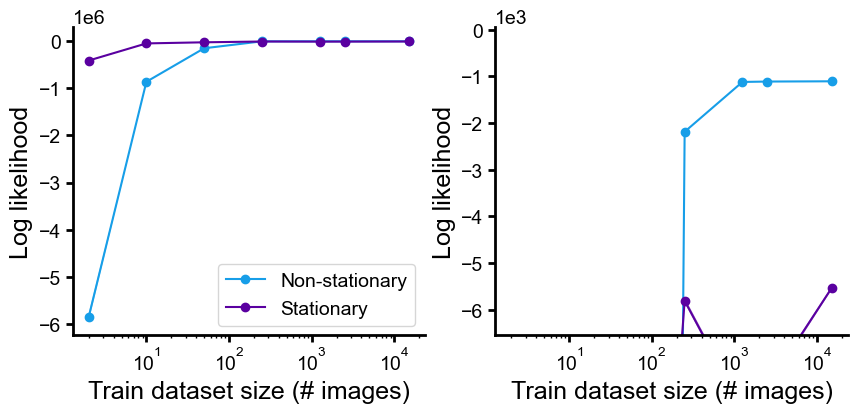

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# plot the log likelihoods of both on the same plot
ax[0].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[0].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[0].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[0].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[0].set(xlabel='Train dataset size (# images)', ylabel='Log likelihood')
ax[0].legend()
clear_spines(ax[0])

# zoom in on the top right 
ax[1].semilogx(num_patches_to_use, log_likelihoods_full_mean, 'o-', label='Non-stationary')
ax[1].semilogx(num_patches_to_use, log_likelihoods_stationary_mean, 'o-', label='Stationary')
ax[1].fill_between(num_patches_to_use, log_likelihoods_full_confidence_interval[:, 0], log_likelihoods_full_confidence_interval[:, 1], alpha=0.5)
ax[1].fill_between(num_patches_to_use, log_likelihoods_stationary_confidence_interval[:, 0], log_likelihoods_stationary_confidence_interval[:, 1], alpha=0.5)
ax[1].set(xlabel='Train dataset size (# images)', ylabel='Log likelihood')
# ax[1].legend()
clear_spines(ax[1])
# take the min and max of both plus a little extra to compute ylim
# ylim_max = np.max(np.concatenate([log_likelihoods_full_confidence_interval[3:], log_likelihoods_stationary_confidence_interval[3:]])) 
# ylim_min = np.min(np.concatenate([log_likelihoods_full_confidence_interval[3:], log_likelihoods_stationary_confidence_interval[3:]])) 
ylim_min = - 6e3
ylim_max = - 5e2
the_range = ylim_max - ylim_min
ax[1].set_ylim([ylim_min - 0.1 * the_range, ylim_max + 0.1 * the_range])
# make this one y labels in scientific notation also
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))


### Show samples from covariance matrices fit with different amounts of data

100%|█████████████████████████████████████████| 7/7 [00:00<00:00, 12.92it/s]
7it [00:00, 283.69it/s]


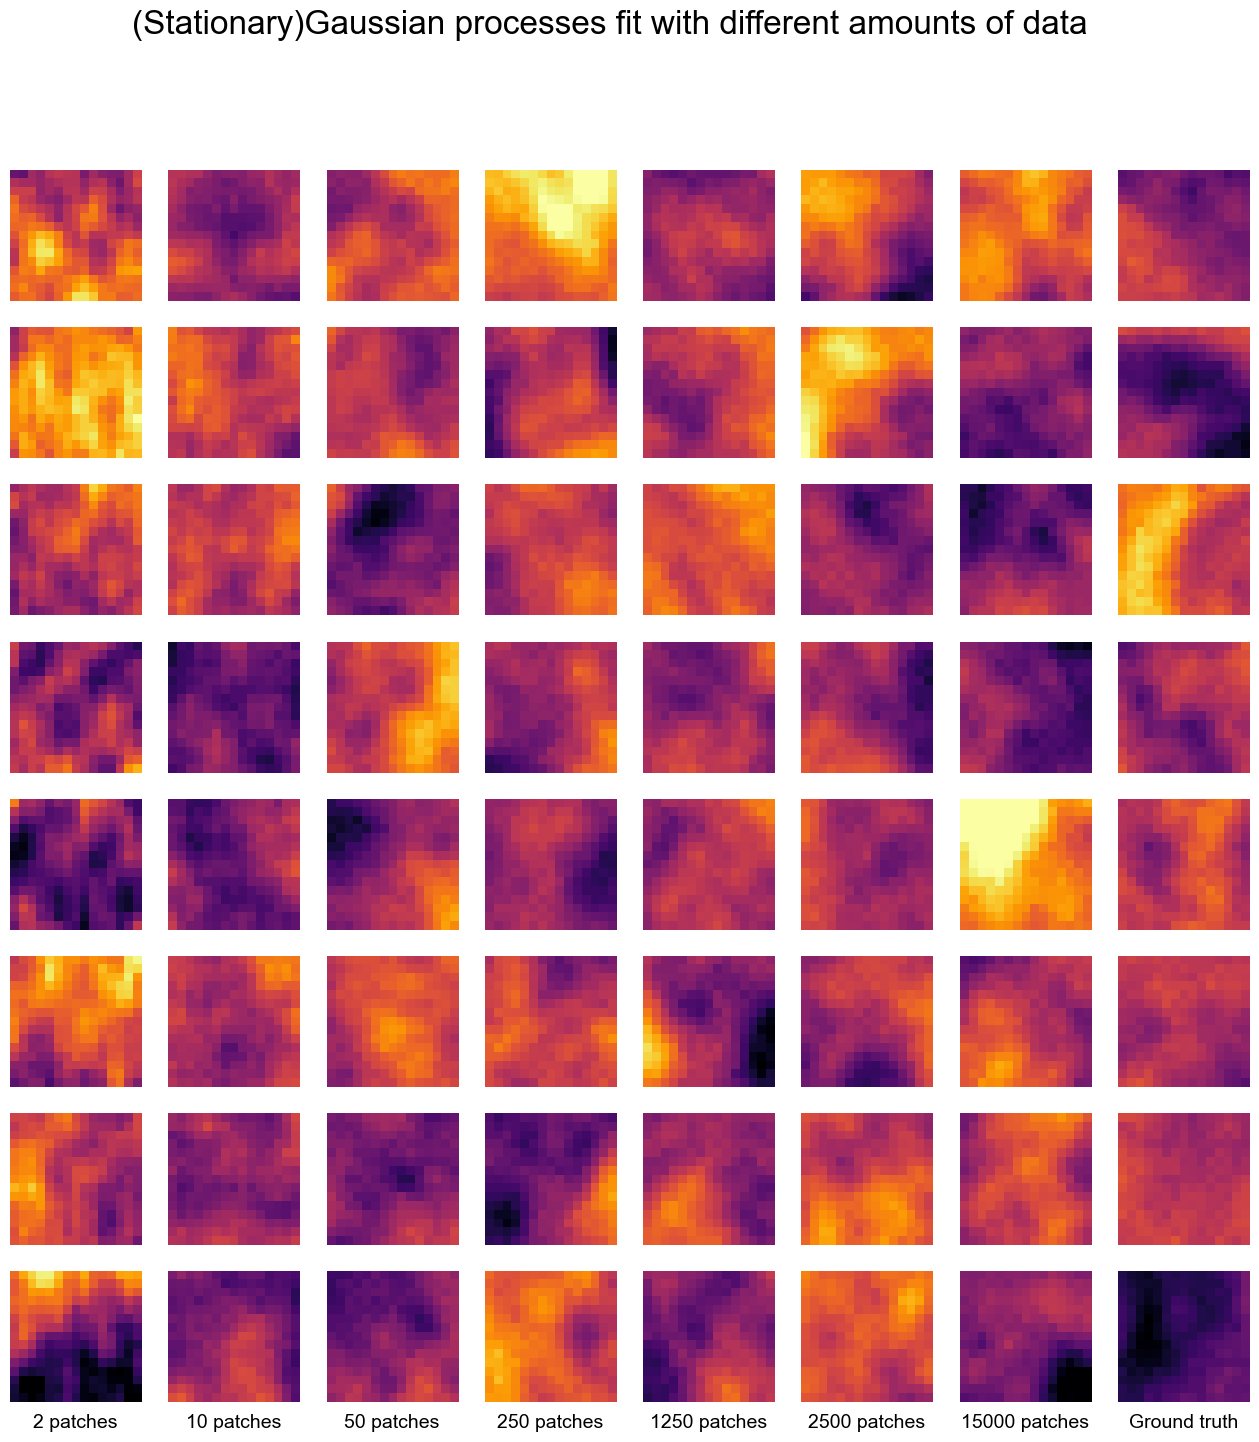

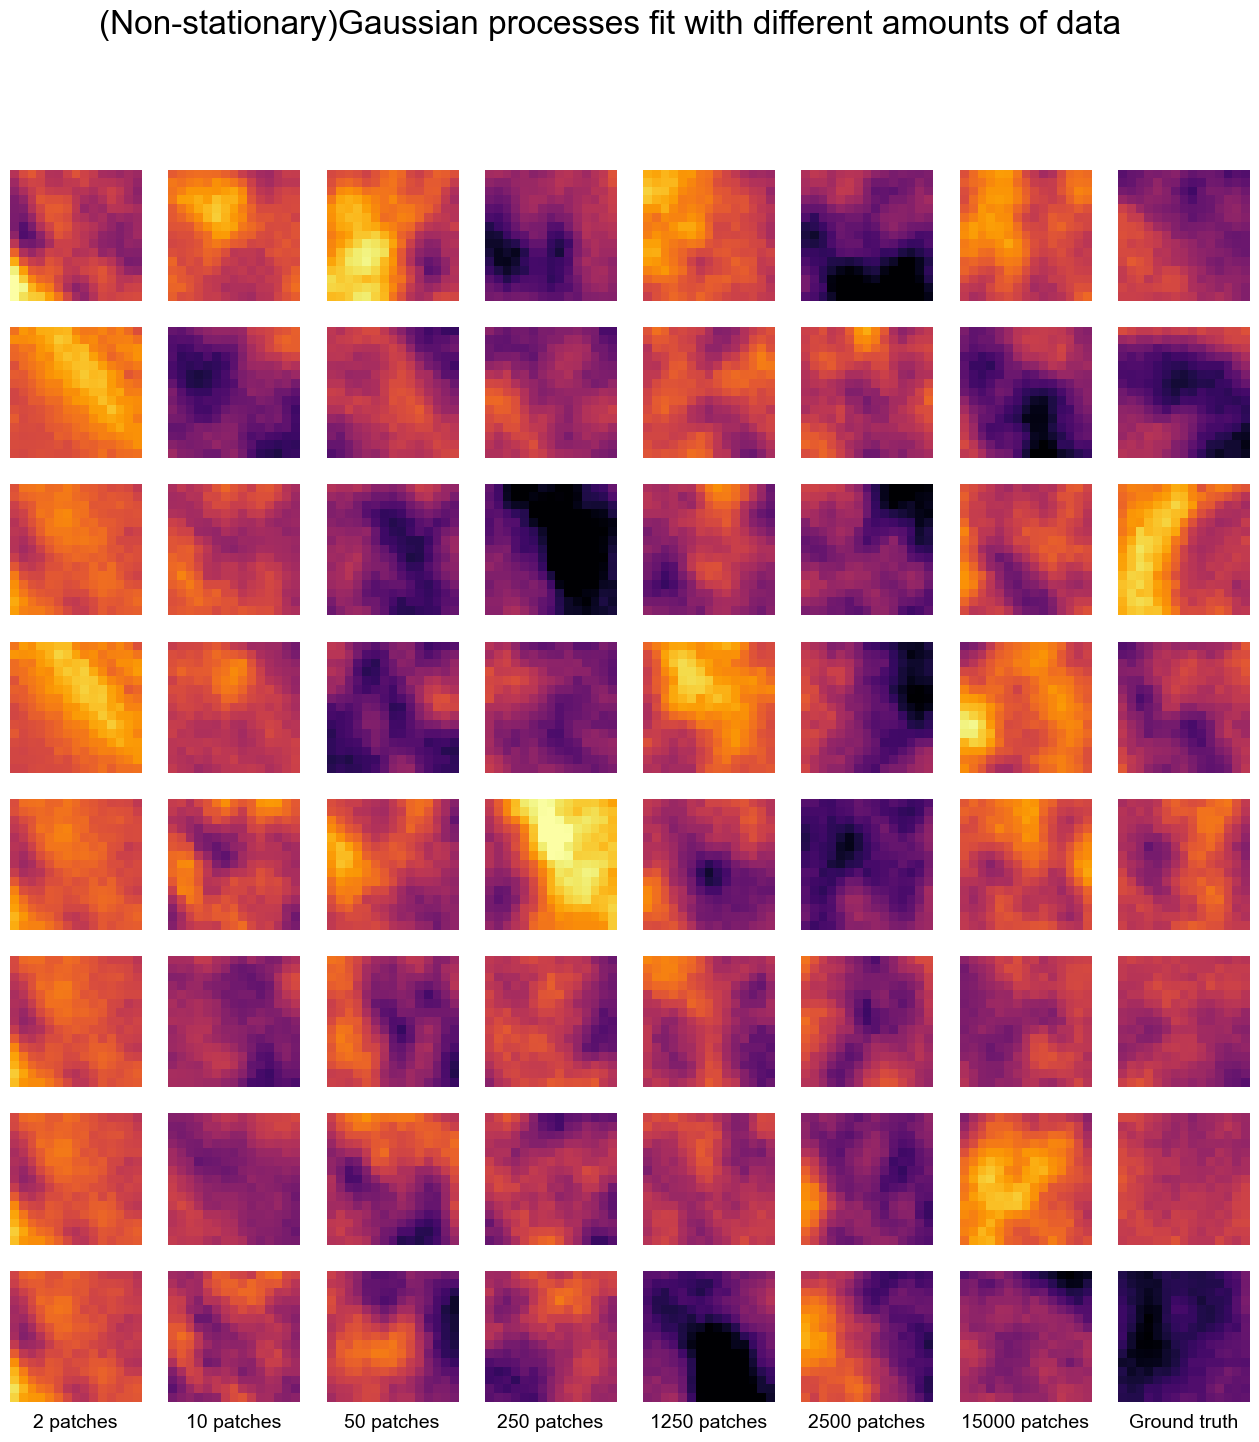

In [6]:
num_samples = 8
sample_size = patch_size

samples_stationary = []
for cov_mat in tqdm(cov_mats_stationary_pd):
    samples_stationary.append(generate_stationary_gaussian_process_samples(cov_mat, sample_size, num_samples, mean=np.mean(patches)))

samples_full = []
for cov_mat, mean in tqdm(zip(cov_mats_pd, non_stationary_means)):
    samples_full.append(generate_multivariate_gaussian_samples(cov_mat, num_samples, mean=mean))

for samples, prefix in zip([samples_stationary, samples_full], ['(Stationary)', '(Non-stationary)']):
    vmin, vmax = np.percentile(patches, 0.3), np.percentile(patches, 99.7)

    # plot samples
    fig, ax = plt.subplots(num_samples, len(cov_mats_pd) + 1, figsize=((len(cov_mats_pd) + 1) , num_samples ), sharex=True, sharey=True)

    for i in range(num_samples):
        for j in range(len(cov_mats_pd)):
            ax[i, j].imshow(samples[j][i], cmap='inferno', vmin=vmin, vmax=vmax)
            clear_spines(ax[i, j])
            if i == num_samples - 1:
                ax[i, j].text(0.5, -0.2, f'{num_patches_to_use[j]} patches', ha='center', transform=ax[i, j].transAxes)
            ax[i, j].axis('off')
        ax[i, -1].imshow(patches[5:][i], cmap='inferno', vmin=vmin, vmax=vmax)
        ax[i, -1].axis('off')
        if i == num_samples - 1:
            ax[i, -1].text(0.5, -0.2, f'Ground truth', ha='center', transform=ax[i, -1].transAxes)

    fig.suptitle(f'{prefix}Gaussian processes fit with different amounts of data')

## Does the MI estimator correctly estimate MI for samples from a stationary process with known MI

stick to additive Gaussian noise, H(Y) can be computed analytically. The covariance matrix for p(y) is just the one for p(x) with sigma**2 * I added to it

In [9]:
# Compute a "true" reference covariance matrix
num_images = 5000
num_patches = 15000
edge_crop = 32
# patch_size = 50
patch_size = 10
channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=True)
patches = extract_patches(images, patch_size, num_patches=num_patches)
cov_mat = compute_cov_mat(patches)
cov_mat_pd = make_positive_definite(cov_mat, eigenvalue_floor=1, show_plot=False)
cov_mat_stationary = compute_stationary_cov_mat(patches)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)


#### Verify that you can estimate a Covariance mat and its analytic entropy from samples of it

100%|█████████████████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]


Text(0.5, 1.0, 'Entropy error\nper pixel')

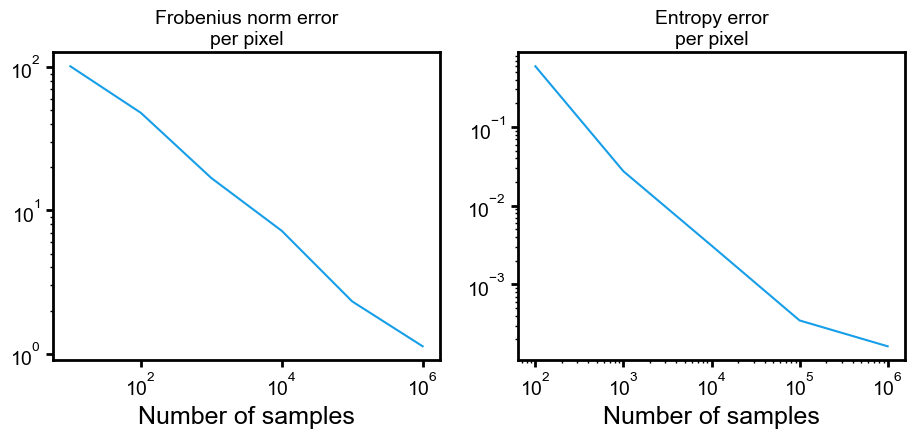

In [10]:
# now sample from the covariance matrix, estimate a new covart
seed = 0
num_samples_list = np.logspace(1, 6, 6, dtype=int)

mat_to_estimate = cov_mat
# mat_to_estimate = cov_mat_stationary_pd

true_entropy = analytic_multivariate_gaussian_entropy(mat_to_estimate) 

fro_norm_errors = []
entropy_errors = []
for num_samples in tqdm(num_samples_list):
    samples = jax.random.multivariate_normal(jax.random.PRNGKey(seed), np.zeros(mat_to_estimate.shape[0]), mat_to_estimate, shape=(num_samples,))
    cov_mat_estimate = compute_cov_mat(samples)
    # compute Frobenius norm of difference between cov_mat_estimate and cov_mat
    error = np.linalg.norm(cov_mat_estimate - mat_to_estimate, ord='fro') / mat_to_estimate.size
    fro_norm_errors.append(error)
    estimated_entropy = analytic_multivariate_gaussian_entropy(cov_mat_estimate) 
    entropy_error = np.abs(estimated_entropy - true_entropy)
    entropy_errors.append(entropy_error)

    
# plot errors
fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].loglog(num_samples_list, fro_norm_errors)
ax[0].set_xlabel('Number of samples')
ax[0].set_title('Frobenius norm error\nper pixel')

ax[1].loglog(num_samples_list, entropy_errors)
ax[1].set_xlabel('Number of samples')
ax[1].set_title('Entropy error\nper pixel')


### Now verify that mutual information estimates converge to the true value with increasing number of samples

In [11]:
# Generate a ground truth covariance matrix for each channel, and then noiseless samples from it

num_images = 10000
num_patches = 50000
edge_crop = 32
# patch_size = 50
# TODO: full size?
patch_size = 12

channel = 'DPC_Right'


images = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=edge_crop, median_filter=False)
patches = extract_patches(images, patch_size, num_patches=num_patches)

cov_mat = compute_cov_mat(patches)
cov_mat_stationary = compute_stationary_cov_mat(patches)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)
true_cov_mat_px = cov_mat_stationary_pd
true_mean_px = np.mean(images)

samples = generate_stationary_gaussian_process_samples(cov_mat_stationary_pd, 
        sample_size=patch_size, num_samples=num_patches, mean=true_mean_px, ensure_nonnegative=True)

### Verify that entrpoy and mutual information estimates are consistent: they converge to the correct value given enough samples
Of course, this is on data that is sampled form a stationary gaussian process, so its only really showing that the gaussian approximation estimator can estimate gaussian entropy and MI. 

Running bootstraps: 100%|█████████████████| 100/100 [00:48<00:00,  2.08it/s]


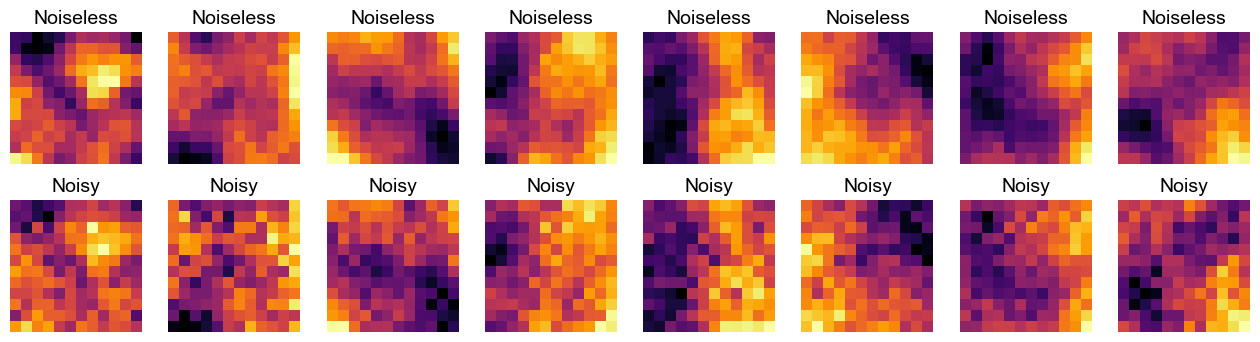

In [12]:
num_samples_to_use = np.array([4, 20, 100, 500, 2500, 5000, 10000, 20000])
num_bootstrap_samples = 100

# num_samples_to_use = np.array([4, 20, 2500])
# num_bootstrap_samples = 10

gaussian_sigma = 50
confidence_interval = 90

h_x_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_px) 
true_cov_mat_py = true_cov_mat_px + gaussian_sigma**2 * np.eye(patch_size**2)
h_y_analytic = analytic_multivariate_gaussian_entropy(true_cov_mat_py) 
# Constant conditional entropy for Gaussian noise
h_y_mid_x_analytic = analytic_multivariate_gaussian_entropy(np.eye(patch_size**2) * gaussian_sigma**2) 
mi_analytic_per_pixel = (h_y_analytic - h_y_mid_x_analytic) / np.log(2)

noisy_samples = add_noise(samples, gaussian_sigma=gaussian_sigma, ensure_positive=True)

# plot several samples and their corresponding noisy samples
num_to_show = 8
fig, ax = plt.subplots(2, num_to_show, figsize=(num_to_show * 2, 4))
for i in range(num_to_show):
    ax[0, i].imshow(samples[i].reshape(patch_size, patch_size), cmap='inferno')
    ax[1, i].imshow(noisy_samples[i].reshape(patch_size, patch_size), cmap='inferno')
    ax[0, i].set_title('Noiseless')
    ax[1, i].set_title('Noisy')
    ax[0,i].axis('off')
    ax[1,i].axis('off')


h_x_estimates_mean = []
h_x_estimates_conf_int = []
h_y_estimates_mean = []
h_y_estimates_conf_int = []
stationary_h_x_estimates_mean = []
stationary_h_x_estimates_conf_int = []
stationary_h_y_estimates_mean = []
stationary_h_y_estimates_conf_int = []
stationary_mi_estimates_mean = []
stationary_mi_estimates_conf_int = []

ev_floor = 1e-4
for num_to_use in num_samples_to_use:
    # estiamte noisy and noiseless entropies using stationary and non-stationary estimators
    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                  lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )                  
    h_x_estimates_mean.append(mean)
    h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )
    stationary_h_x_estimates_mean.append(mean)
    stationary_h_x_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=False, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval )
    h_y_estimates_mean.append(mean)
    h_y_estimates_conf_int.append(conf_int)

    mean, conf_int = run_bootstrap(noisy_samples[:num_to_use], num_bootstrap_samples=num_bootstrap_samples, estimation_fn=
                    lambda data: gaussian_entropy_estimate(data, stationary=True, eigenvalue_floor=ev_floor, show_plot=False), confidence_interval=confidence_interval)
    stationary_h_y_estimates_mean.append(mean)
    stationary_h_y_estimates_conf_int.append(conf_int)

    # estimate MI using stationary estimator
    mean, conf_int = run_bootstrap({'noisy_images': noisy_samples[:num_to_use], 'clean_images': samples[:num_to_use]}, 
                    num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, estimation_fn=
                    lambda noisy_images, clean_images: estimate_mutual_information(noisy_images, clean_images, use_stationary_model=True,
                     eigenvalue_floor=ev_floor, gaussian_noise_sigma = gaussian_sigma, ) )
    stationary_mi_estimates_mean.append(mean)
    stationary_mi_estimates_conf_int.append(conf_int)


h_x_estimates_conf_int = np.array(h_x_estimates_conf_int)
h_x_estimates_mean = np.array(h_x_estimates_mean)
h_y_estimates_conf_int = np.array(h_y_estimates_conf_int)
h_y_estimates_mean = np.array(h_y_estimates_mean)
stationary_h_x_estimates_conf_int = np.array(stationary_h_x_estimates_conf_int)
stationary_h_x_estimates_mean = np.array(stationary_h_x_estimates_mean)
stationary_h_y_estimates_conf_int = np.array(stationary_h_y_estimates_conf_int)
stationary_h_y_estimates_mean = np.array(stationary_h_y_estimates_mean)
stationary_mi_estimates_conf_int = np.array(stationary_mi_estimates_conf_int)
stationary_mi_estimates_mean = np.array(stationary_mi_estimates_mean)

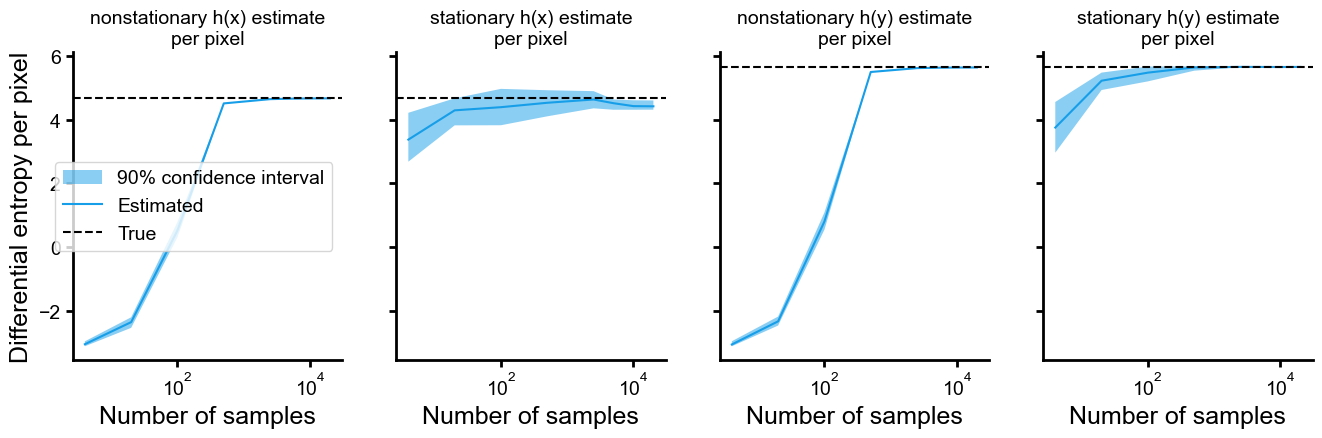

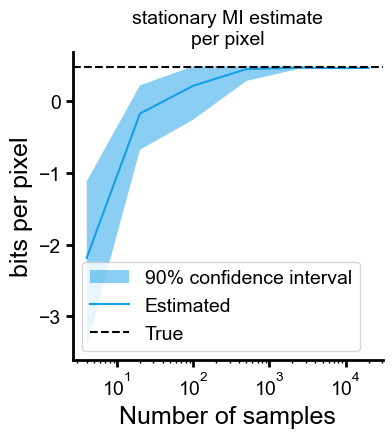

In [13]:
    
# plot estimates vs true value
fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)

ax[0].fill_between(num_samples_to_use, h_x_estimates_conf_int[:,0], h_x_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax[0].semilogx(num_samples_to_use, h_x_estimates_mean, label='Estimated')
ax[0].axhline(h_x_analytic, color='k', linestyle='--', label='True')
ax[0].set(xlabel='Number of samples', title='nonstationary h(x) estimate\nper pixel', ylabel='Differential entropy per pixel')
clear_spines(ax[0])
ax[0].legend()

ax[1].fill_between(num_samples_to_use, stationary_h_x_estimates_conf_int[:,0], stationary_h_x_estimates_conf_int[:,1], alpha=0.5)
ax[1].semilogx(num_samples_to_use, stationary_h_x_estimates_mean)
ax[1].axhline(h_x_analytic, color='k', linestyle='--')
ax[1].set(xlabel='Number of samples', title='stationary h(x) estimate\nper pixel')
clear_spines(ax[1])

ax[2].fill_between(num_samples_to_use, h_y_estimates_conf_int[:,0], h_y_estimates_conf_int[:,1], alpha=0.5)
ax[2].semilogx(num_samples_to_use, h_y_estimates_mean)
ax[2].axhline(h_y_analytic, color='k', linestyle='--')
ax[2].set(xlabel='Number of samples', title='nonstationary h(y) estimate\nper pixel')
clear_spines(ax[2])

ax[3].fill_between(num_samples_to_use, stationary_h_y_estimates_conf_int[:,0], stationary_h_y_estimates_conf_int[:,1], alpha=0.5)
ax[3].semilogx(num_samples_to_use, stationary_h_y_estimates_mean)
ax[3].axhline(h_y_analytic, color='k', linestyle='--')
ax[3].set(xlabel='Number of samples', title='stationary h(y) estimate\nper pixel')
clear_spines(ax[3])


fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.fill_between(num_samples_to_use, stationary_mi_estimates_conf_int[:,0], stationary_mi_estimates_conf_int[:,1], alpha=0.5, label=f'{confidence_interval}% confidence interval')
ax.semilogx(num_samples_to_use, stationary_mi_estimates_mean, label='Estimated')
ax.axhline(mi_analytic_per_pixel, color='k', linestyle='--', label='True')
ax.set(xlabel='Number of samples', title='stationary MI estimate\nper pixel', ylabel='bits per pixel')
clear_spines(ax)
ax.legend()


### Make sure the cov mats look like what you expect

Text(0.5, 1.0, 'Estimated stationary + PD covariance matrix')

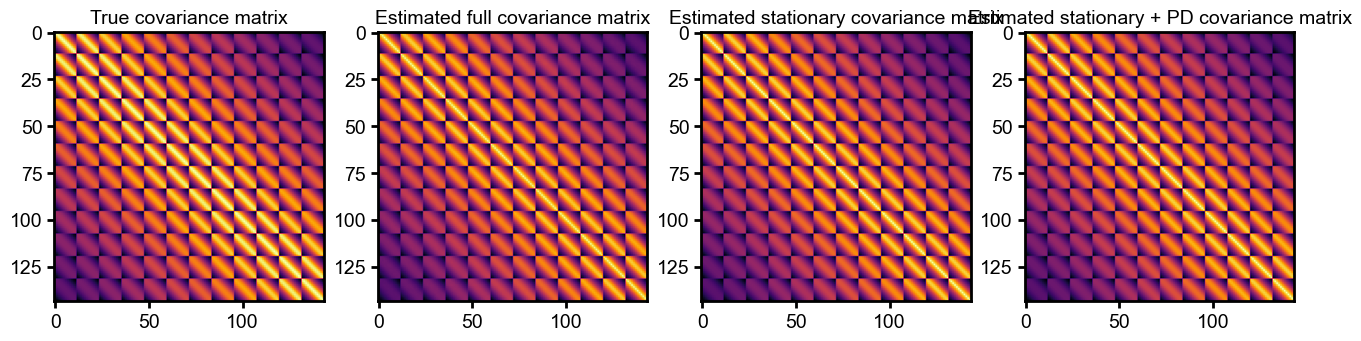

In [14]:
_, cov_mat_full = gaussian_entropy_estimate(noisy_samples, stationary=False, eigenvalue_floor=ev_floor, show_plot=False, return_cov_mat=True)
_, cov_mat_stationary = gaussian_entropy_estimate(noisy_samples, stationary=True, eigenvalue_floor=ev_floor, show_plot=False, return_cov_mat=True)
cov_mat_stationary_pd = make_positive_definite(cov_mat_stationary, eigenvalue_floor=1, show_plot=False)

# imshow cov_mat_full
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
ax[0].imshow(true_cov_mat_px, cmap='inferno')
ax[0].set_title('True covariance matrix')
ax[1].imshow(cov_mat_full, cmap='inferno')
ax[1].set_title('Estimated full covariance matrix')
ax[2].imshow(cov_mat_stationary, cmap='inferno')
ax[2].set_title('Estimated stationary covariance matrix')
ax[3].imshow(cov_mat_stationary_pd, cmap='inferno')
ax[3].set_title('Estimated stationary + PD covariance matrix')

## Is H(Y | X) well approximated by H(Y_theoretical | Y_experimental)

### Load images

100%|████████████████████████████████████████| 3/3 [08:31<00:00, 170.60s/it]


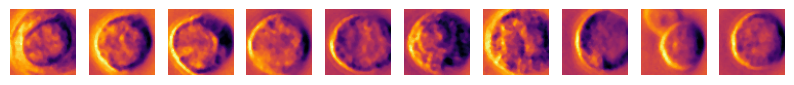

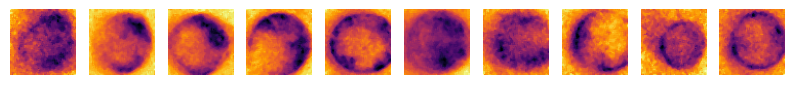

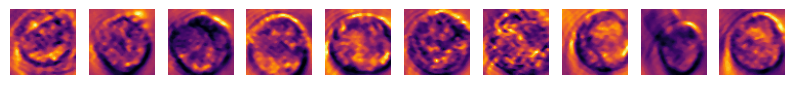

In [15]:
num_images = 10000
channels = ['DPC_Right', 'Brightfield', 'LED119']
# channels = ['LED119']

images = {}
clean_patches_by_channel = {}
for channel in tqdm(channels):
    # load "clean" median filtered images
    images[channel] = load_bsccm_images(bsccm, channel=channel, num_images=num_images, edge_crop=32, median_filter=True)        
    clean_patches_by_channel[channel] = extract_patches(images[channel], patch_size, num_patches=num_patches)

    # plot a montage of images
    num_to_plot = 10
    fig, ax = plt.subplots(1, num_to_plot, figsize=(num_to_plot, 1))
    for i in range(num_to_plot):
        ax[i].imshow(images[channel][i], cmap='inferno')
        ax[i].axis('off')

### Compare conditional entropy of noisy to clean

In [16]:
mean_photons = {channel: np.mean(images[channel]) for channel in images.keys()}
photons_per_pixel_list = [20, 40, 80, 160, 320]
num_bootstraps = 10
patch_size = 15
num_patches = 10000
confidence_interval = 90

results = {}
for channel in channels:
    results[channel] = []
    for photons_per_pixel in tqdm(photons_per_pixel_list):
        rescale_fractions = {channel: photons_per_pixel / mean_photons[channel] for channel in images.keys()}
        clean_patches = clean_patches_by_channel[channel] * rescale_fractions[channel]
        noisy_patches = add_noise(clean_patches, ensure_positive=True)

        noisy_conditional_mean, noisy_conditional_interval = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                             lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
        clean_conditional_mean, clean_conditional_interval = run_bootstrap({'clean_images': clean_patches, 'noisy_images': noisy_patches},
                                                                            num_bootstrap_samples=num_bootstraps, confidence_interval=confidence_interval, estimation_fn=
                                                                lambda noisy_images, clean_images: estimate_mutual_information(noisy_images=noisy_images, clean_images=clean_images, verbose=False))
        results[channel].append((noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval))
        

Running bootstraps:   0%|                            | 0/10 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 19.83. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:  10%|██                  | 1/10 [00:01<00:15,  1.72s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 19.80. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:  30%|██████              | 3/10 [00:02<00:05,  1.32it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: User

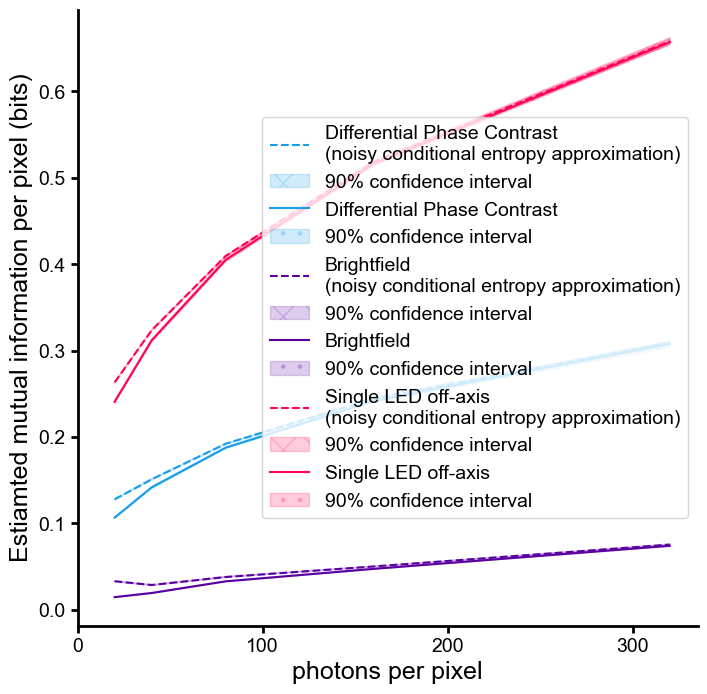

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
colors = get_color_cycle()
for color, (channel, channel_results) in zip(colors, results.items()):
    noisy_conditional_means = []
    noisy_conditional_intervals = []
    clean_conditional_means = []
    clean_conditional_intervals = []
    for noisy_conditional_mean, noisy_conditional_interval, clean_conditional_mean, clean_conditional_interval in channel_results:
        noisy_conditional_means.append(noisy_conditional_mean)
        noisy_conditional_intervals.append(noisy_conditional_interval)
        clean_conditional_means.append(clean_conditional_mean)
        clean_conditional_intervals.append(clean_conditional_interval)
    noisy_conditional_means = np.array(noisy_conditional_means)
    noisy_conditional_intervals = np.array(noisy_conditional_intervals)
    clean_conditional_means = np.array(clean_conditional_means)
    clean_conditional_intervals = np.array(clean_conditional_intervals)
    
    channel_name = get_display_channel_names(channel)
    ax.plot(photons_per_pixel_list, noisy_conditional_means, '--',label=channel_name + '\n(noisy conditional entropy approximation)', color=color)
    ax.fill_between(photons_per_pixel_list, noisy_conditional_intervals[:, 0], noisy_conditional_intervals[:, 1], alpha=0.2, color=color, hatch='x', label=f'{confidence_interval}% confidence interval')
    ax.plot(photons_per_pixel_list, clean_conditional_means, '-', label=channel_name , color=color)
    ax.fill_between(photons_per_pixel_list, clean_conditional_intervals[:, 0], clean_conditional_intervals[:, 1], alpha=0.2, color=color, hatch='.', label=f'{confidence_interval}% confidence interval')
    ax.set(xticks=[0, 100, 200, 300])

clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estiamted mutual information per pixel (bits)')
ax.legend()

## TODO: the bar chart for figure 2

In [18]:
# # create sample data
# channel_names = ['Channel 1', 'Channel 2', 'Channel 3']
# experimental_data = [10, 20, 30]
# non_experimental_data = [15, 25, 35]

# # create a paired bar plot of results
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# colors = get_color_cycle()

# # set the width of the bars
# bar_width = 0.35

# # create the bar plots
# experimental_bars = ax.bar(np.arange(len(channel_names)), experimental_data, width=bar_width, color=colors[0], label='Experimental')
# non_experimental_bars = ax.bar(np.arange(len(channel_names)) + bar_width, non_experimental_data, width=bar_width, color=colors[1], label='Non-experimental')

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2)
# ax.set_xticklabels(channel_names)
# ax.set_ylabel('Data')
# ax.set_title('Experimental vs Non-experimental Data')
# ax.legend()

## TODO: Whats happening here??? Why does addin shot noise to experimental data not work?

In [19]:
# edge_crop = 24
# patch_size = 50
# channel = 'LED119'

# num_images = 10000
# num_patches = 10000

# photons_per_pixel = 150

# images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
# patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

# noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
# # noisy_patches = add_shot_noise(patches * photons_per_pixel / np.mean(images))
# estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, eigenvalue_floor=1, verbose=True)

# # cov_mat = compute_stationary_cov_mat(noisy_patches, verbose=True)
# # evs = np.linalg.eigvalsh(cov_mat)

# # # plot them
# # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# # ax.semilogy(evs)

## Information vs number of photons
Show all three channels and how they asumptote so collecting data at higher and higher SNR cant save you if encoding is bad
(i.e. sublinear returns on SNR)

In [20]:
edge_crop = 32
patch_size = 15

num_images = 10000
num_patches = 10000

photons_per_pixel_values = [10, 25, 50, 100, 200, 400, 800]

channel = 'DPC_Right'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

mi_means = []
mi_confidences = []

noisy_patches_for_display = []
for photons_per_pixel in tqdm(photons_per_pixel_values):
    # TODO: this doesnt work?
    # noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    noisy_patches_for_display.append(noisy_patches[:10])

mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)

Running bootstraps:   0%|                            | 0/50 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 9.87. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:   2%|▍                   | 1/50 [00:02<02:00,  2.46s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 9.88. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")

Running bootstraps:   4%|▊                   | 2/50 [00:03<01:11,  1.48s/it]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWa

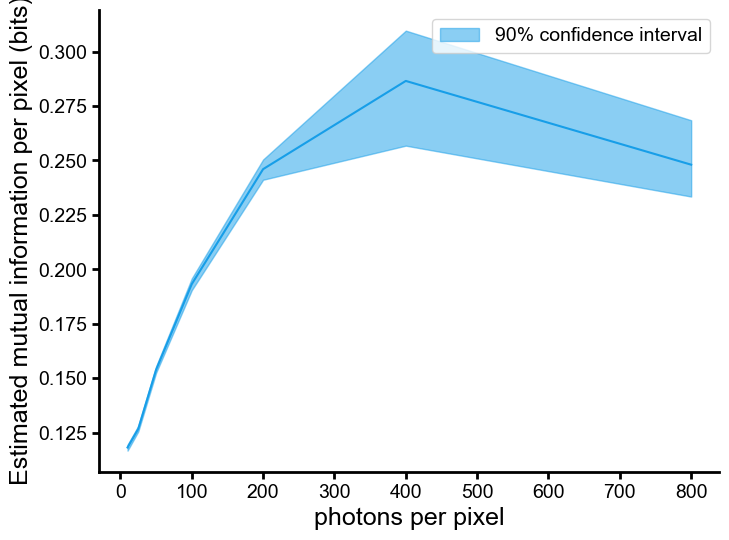

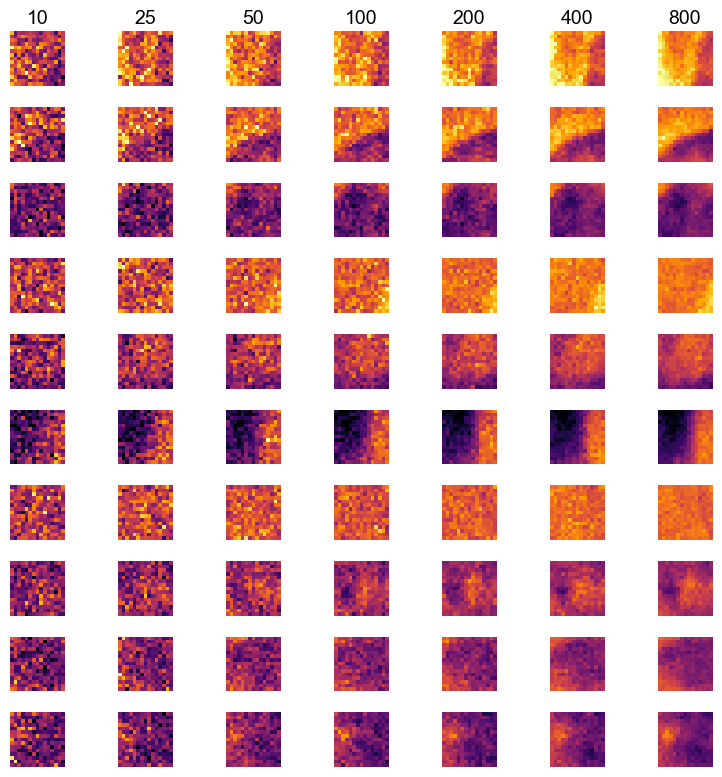

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], alpha=0.5, label='90% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()

fig, axs = plt.subplots(len(noisy_patches_for_display[0]), len(noisy_patches_for_display), figsize=(8, 8))
for i, noisy_patches in enumerate(noisy_patches_for_display):
    vmin, vmax = np.percentile(noisy_patches, 0.3), np.percentile(noisy_patches, 99.7)
    for j, patch in enumerate(noisy_patches):
        axs[j, i].imshow(patch, cmap='inferno', vmin=vmin, vmax=vmax)
        axs[j, i].axis('off')
        if i == 0:
            axs[j, i].set_ylabel(f'Patch {j+1}')
        if j == 0:
            axs[j, i].set_title(f'{photons_per_pixel_values[i]}')
plt.tight_layout()


# TODO mutual infor estimation at very low photon counts

## TODO: How do samples from GP approx look like with different patch sizes:
- starting from 1 pixel
- maybe this belongs in the other notebook